## Set up Workspace

### Steps

1. Read in data
2. Regrid to 0.25 deg Lat-Lon grid
3. Align time
4. Bias Correct
5. Awaiting comparison to code in R

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate, stats
import xesmf as xe
from datetime import datetime, timedelta

%matplotlib inline

In [2]:
var = 'uas'

## Look at Data

In [3]:
hist_file = '../../Seth Comparison/uas.hist.CanESM2.CRCM5-UQAM.day.NAM-44i.raw.nc'
ds_hist = xr.open_dataset(hist_file)

In [4]:
ds_hist

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 129, lon: 300, time: 20440)
Coordinates:
  * time       (time) object 1950-01-01 12:00:00 ... 2005-12-31 12:00:00
  * lat        (lat) float64 12.25 12.75 13.25 13.75 ... 74.75 75.25 75.75 76.25
  * lon        (lon) float64 -171.8 -171.2 -170.8 ... -23.25 -22.75 -22.25
Dimensions without coordinates: bnds
Data variables:
    uas        (time, lat, lon) float32 ...
    time_bnds  (time, bnds) object ...
Attributes:
    Conventions:                    CF-1.4
    institution:                    Universite du Quebec a Montreal
    contact:                        Winger.Katja@uqam.ca
    comment:                        CORDEX North America CRCM5 v333 0.44 deg ...
    model:                          CRCM5 (dynamics GEM v_3.3.3, physics RPN ...
    model_grid:                     rotated lat-lon 236x241 incl. 10p pilot a...
    geophysical_fields:             orography: USGS / land use cover: USGS / ...
    physics:                        land: C

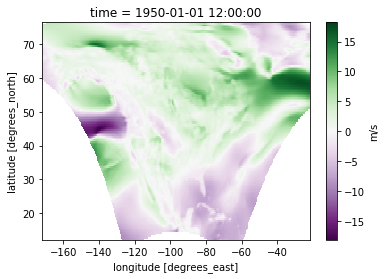

In [5]:
ds_hist[var].isel(time=0).plot(x="lon", y="lat", cmap="PRGn", cbar_kwargs={"label": "m/s"})

In [6]:
rcp85_file = '../../Seth Comparison/uas.rcp85.CanESM2.CRCM5-UQAM.day.NAM-44i.raw.nc'
ds_rcp85 = xr.open_dataset(hist_file)

In [7]:
ds_rcp85

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 129, lon: 300, time: 20440)
Coordinates:
  * time       (time) object 1950-01-01 12:00:00 ... 2005-12-31 12:00:00
  * lat        (lat) float64 12.25 12.75 13.25 13.75 ... 74.75 75.25 75.75 76.25
  * lon        (lon) float64 -171.8 -171.2 -170.8 ... -23.25 -22.75 -22.25
Dimensions without coordinates: bnds
Data variables:
    uas        (time, lat, lon) float32 ...
    time_bnds  (time, bnds) object ...
Attributes:
    Conventions:                    CF-1.4
    institution:                    Universite du Quebec a Montreal
    contact:                        Winger.Katja@uqam.ca
    comment:                        CORDEX North America CRCM5 v333 0.44 deg ...
    model:                          CRCM5 (dynamics GEM v_3.3.3, physics RPN ...
    model_grid:                     rotated lat-lon 236x241 incl. 10p pilot a...
    geophysical_fields:             orography: USGS / land use cover: USGS / ...
    physics:                        land: C

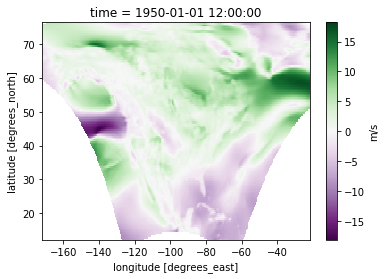

In [8]:
ds_rcp85[var].isel(time=0).plot(x="lon", y="lat", cmap="PRGn", cbar_kwargs={"label": "m/s"})

In [9]:
meas_file = '../../Seth Comparison/uas.gridMET.NAM-44i.nc'
ds_meas = xr.open_dataset(meas_file)

In [10]:
ds_meas

<xarray.Dataset>
Dimensions:      (bnds: 2, lat: 129, lon: 300, time: 13880)
Coordinates:
  * time         (time) datetime64[ns] 1979-01-01T19:00:00 ... 2016-12-31T19:00:00
  * lat          (lat) float64 12.25 12.75 13.25 13.75 ... 75.25 75.75 76.25
  * lon          (lon) float64 -171.8 -171.2 -170.8 ... -23.25 -22.75 -22.25
Dimensions without coordinates: bnds
Data variables:
    uas          (time, lat, lon) float32 ...
    lat_bnds     (lat, bnds) float32 ...
    lon_bnds     (lon, bnds) float32 ...
    crs          int32 ...
    data_status  (time) int8 ...
    time_bnds    (time, bnds) datetime64[ns] ...
Attributes:
    author:                    John Abatzoglou - University of Idaho, jabatzo...
    creation_date:             10 March 2016
    Conventions:               CF-1.6
    title:                     gridMET gridded surface meteorological data
    institution:               University of Idaho
    contact:                   John Abatzoglou, jabatzoglou@uidaho.edu
    URL:  

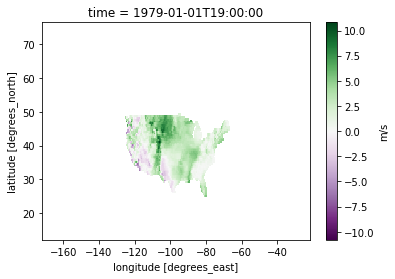

In [11]:
ds_meas[var].isel(time=0).plot(x="lon", y="lat", cmap="PRGn", cbar_kwargs={"label": "m/s"})

## Filter Data
Here you would also regrid data if necessary!

In [12]:
wesn = [-110, -102, 37, 41] #Limit to Size of Colorado

In [13]:
ds_meas_flt = ds_meas.sel(lon = slice(wesn[0], wesn[1]),lat = slice(wesn[2], wesn[3]))
ds_hist_flt = ds_hist.sel(lon = slice(wesn[0], wesn[1]),lat = slice(wesn[2], wesn[3]))
ds_rcp85_flt = ds_rcp85.sel(lon = slice(wesn[0], wesn[1]),lat = slice(wesn[2], wesn[3]))

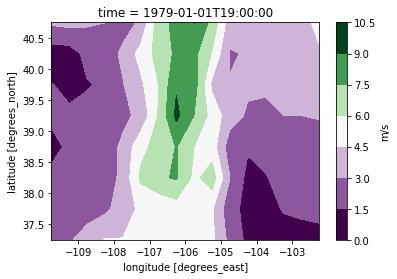

In [14]:
ds_meas_flt[var].isel(time=0).plot.contourf(x="lon", y="lat", cmap="PRGn", cbar_kwargs={"label": "m/s"})

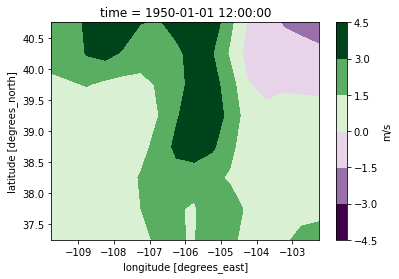

In [15]:
ds_hist_flt[var].isel(time=0).plot.contourf(x="lon", y="lat", cmap="PRGn", cbar_kwargs={"label": "m/s"})

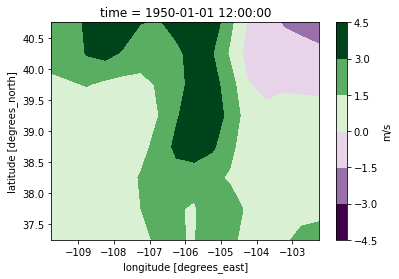

In [16]:
ds_rcp85_flt[var].isel(time=0).plot.contourf(x="lon", y="lat", cmap="PRGn", cbar_kwargs={"label": "m/s"})

## Align Time

There are many options for dealing with leap years. Here we drop December 31st every leap year (whenever there is a 366th day of the year drop it), but for some variables other methods might be preferable. 

In [17]:
ds_meas_noleap = ds_meas_flt.sel(time=~((ds_meas_flt.time.dt.dayofyear == 366) ))

In [18]:
def _cfnoleap_to_datetime(da):
    datetimeindex = da.indexes['time'].to_datetimeindex()
    ds = da#.to_dataset()
    ds['time_dt']= ('time', datetimeindex)
    ds = ds.swap_dims({'time': 'time_dt'})
    assert len(da.time) == len(ds.time_dt)
    return ds

In [19]:
ds_hist_dt = _cfnoleap_to_datetime(ds_hist_flt)   

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  


In [20]:
ds_rcp85_dt = _cfnoleap_to_datetime(ds_rcp85_flt)  

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  


In [21]:
def _regroup_models_bytime(ds_meas, ds_hist_dt, ds_rcp_dt):
    t0_meas = ds_meas.time[0]
    tn_meas = ds_meas.time[-1]
    t0_fut = tn_meas.values + np.timedelta64(1, 'D')
    
    ds_past = ds_hist_dt.sel(time_dt = slice(t0_meas, tn_meas))
    ds_past = ds_past.swap_dims({'time_dt':'time'})
    
    ds_fut_pt1 = ds_hist_dt.sel(time_dt = slice(t0_fut,None))
    ds_fut = xr.concat([ds_fut_pt1[var], ds_rcp_dt[var]], 'time_dt')
    ds_fut = ds_fut.swap_dims({'time_dt':'time'})
    return ds_past, ds_fut

In [22]:
ds_past, ds_fut = _regroup_models_bytime(ds_meas_noleap, ds_hist_dt, ds_rcp85_dt)

## Bias Correction

Things to be added to this section:   
- Bias correction methods other than zscore:
    - scale (for wind speed, wave flux in air)
    - log (for precipitation)
    - range (relative humidity)
    - seth mcginnes's kddm (for any bimodal distributions)

In [23]:
def _reshape(ds, window_width):
    split = lambda g: (g.rename({'time': 'day'})
                       .assign_coords(day=g.time.dt.dayofyear.values))
    ds2 = ds.groupby('time.year').apply(split)
    
    early_Jans = ds2.isel(day = slice(None,window_width//2))
    late_Decs = ds2.isel(day = slice(-window_width//2,None))
    
    ds3 = xr.concat([late_Decs,ds2,early_Jans],dim='day')
    return ds3

def _calc_stats(ds, window_width):
    ds_rsh = _reshape(ds, window_width)
    
    ds_rolled = ds_rsh.rolling(day=window_width, center=True).construct('win_day')
    
    n = window_width//2+1
    ds_mean = ds_rolled.mean(dim=['year','win_day']).isel(day=slice(n,-n))
    ds_std = ds_rolled.std(dim=['year','win_day']).isel(day=slice(n,-n))
    
    ds_avyear = ds_rsh.mean(dim=['year','day'])
    ds_zscore = ((ds_avyear - ds_mean) / ds_std)
    return ds_mean, ds_std, ds_zscore

def _calc_fut_stats(ds_fut, window_width):
    ds_rolled = ds_fut.rolling(time=window_width, center=True).construct('win_day')
    
    ds_mean = ds_rolled.mean(dim=['win_day'])
    ds_std = ds_rolled.std(dim=['win_day'])
    
    ds_avyear = ds_fut.mean(dim=['time'])
    ds_zscore = ((ds_avyear - ds_mean) / ds_std)
    return ds_mean, ds_std, ds_zscore

In [24]:
window_width=31

meas_mean, meas_std, meas_zscore = _calc_stats(ds_meas_noleap, window_width)
hist_mean, hist_std, hist_zscore = _calc_stats(ds_past, window_width)
fut_typ_mean, fut_typ_std, fut_typ_zscore = _calc_stats(ds_fut, window_width)

In [25]:
fut_mean, fut_std, fut_zscore = _calc_fut_stats(ds_fut, window_width)

In [26]:
def _get_params(meas_mean, meas_std, past_mean, past_std):    
    shift = meas_mean - past_mean
    scale = meas_std / past_std
    return shift, scale

shift, scale = _get_params(meas_mean, meas_std, hist_mean, hist_std)

In [27]:
fut_mean_bc = fut_mean + shift
fut_std_bc = fut_std * scale

fut_corrected = (fut_zscore * fut_std_bc) + fut_mean_bc

In [28]:
fut_typ_mean_bc = fut_typ_mean + shift
fut_typ_std_bc = fut_typ_std * scale

In [29]:
hist_mean[var]

<xarray.DataArray 'uas' (day: 364, lat: 8, lon: 16)>
array([[[0.29484 , 0.262617, ..., 1.586784, 1.53362 ],
        [0.27244 , 0.341796, ..., 1.43937 , 1.417508],
        ...,
        [0.774677, 0.443943, ..., 2.056974, 2.151886],
        [0.752915, 0.696045, ..., 2.153647, 2.220504]],

       [[0.299096, 0.261314, ..., 1.588901, 1.534766],
        [0.276454, 0.341347, ..., 1.432298, 1.410903],
        ...,
        [0.769977, 0.43686 , ..., 2.03611 , 2.130305],
        [0.749213, 0.6883  , ..., 2.133954, 2.20066 ]],

       ...,

       [[0.284591, 0.258228, ..., 1.628101, 1.577353],
        [0.274235, 0.346178, ..., 1.498606, 1.477206],
        ...,
        [0.789603, 0.458755, ..., 2.143934, 2.237256],
        [0.769435, 0.715118, ..., 2.237214, 2.305357]],

       [[0.285297, 0.253814, ..., 1.609528, 1.554371],
        [0.271246, 0.340516, ..., 1.474163, 1.447954],
        ...,
        [0.792469, 0.460969, ..., 2.118936, 2.216418],
        [0.766953, 0.714598, ..., 2.215286, 2.28695

In [30]:
fut_std

<xarray.DataArray (time: 20440, lat: 8, lon: 16)>
array([[[1.053501, 1.111329, ..., 2.208192, 2.340808],
        [0.830818, 0.928433, ..., 2.1713  , 2.266445],
        ...,
        [1.063869, 0.943727, ..., 2.389834, 2.472305],
        [0.79059 , 0.790936, ..., 2.718297, 2.786285]],

       [[1.055462, 1.10227 , ..., 2.158875, 2.296626],
        [0.82546 , 0.907492, ..., 2.14651 , 2.251899],
        ...,
        [1.032231, 0.943467, ..., 2.378624, 2.439418],
        [0.768915, 0.767335, ..., 2.683819, 2.733351]],

       ...,

       [[0.94781 , 1.012255, ..., 1.232359, 1.23157 ],
        [0.758141, 0.791967, ..., 1.157384, 1.400707],
        ...,
        [1.085436, 0.870309, ..., 2.007994, 2.266523],
        [0.719467, 0.609133, ..., 2.105784, 2.252195]],

       [[0.952804, 1.014192, ..., 1.266026, 1.269035],
        [0.780719, 0.815242, ..., 1.192873, 1.443461],
        ...,
        [1.087388, 0.864707, ..., 2.049421, 2.295232],
        [0.737172, 0.627711, ..., 2.142454, 2.268488]]

In [31]:
fut_typ_mean

<xarray.DataArray (lat: 8, lon: 16, day: 364)>
array([[[0.308348, 0.312148, ..., 0.329927, 0.319646],
        [0.263914, 0.266052, ..., 0.289125, 0.274968],
        ...,
        [1.583792, 1.586238, ..., 1.644365, 1.622133],
        [1.524491, 1.529601, ..., 1.584505, 1.562347]],

       [[0.290257, 0.292463, ..., 0.313156, 0.301528],
        [0.348181, 0.347924, ..., 0.374401, 0.36054 ],
        ...,
        [1.423788, 1.420216, ..., 1.494012, 1.468464],
        [1.398324, 1.397159, ..., 1.465574, 1.439154]],

       ...,

       [[0.864992, 0.8568  , ..., 0.896779, 0.89289 ],
        [0.513457, 0.504597, ..., 0.54255 , 0.538885],
        ...,
        [2.041385, 2.027129, ..., 2.099935, 2.082026],
        [2.13886 , 2.1215  , ..., 2.196898, 2.17979 ]],

       [[0.805314, 0.800716, ..., 0.828225, 0.822744],
        [0.761408, 0.755346, ..., 0.786862, 0.782389],
        ...,
        [2.146528, 2.130881, ..., 2.205305, 2.188615],
        [2.203328, 2.185553, ..., 2.261682, 2.247254]]], 

In [32]:
def gaus(mean, std, doy):
    a = mean.sel(day=doy)
    mu = a.isel(lon = 5, lat = 5)

    b =std.sel(day=doy)
    sigma = b.isel(lon = 5, lat = 5)

    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    y = stats.norm.pdf(x, mu, sigma)
    return x, y

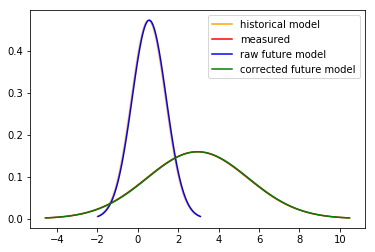

In [33]:
doy=20
plt.figure()
x,y = gaus(hist_mean[var], hist_std[var], doy)
plt.plot(x, y, 'orange', label = 'historical model')
x,y = gaus(meas_mean[var], meas_std[var], doy)
plt.plot(x, y, 'red', label = 'measured')
x,y = gaus(fut_typ_mean, fut_typ_std, doy)
plt.plot(x, y, 'blue', label = 'raw future model')
x,y = gaus(fut_typ_mean_bc[var], fut_typ_std_bc[var], doy)
plt.plot(x, y, 'green', label = 'corrected future model')
plt.legend()